###### Using thermodynamic analysis to guide metabolic engineering
DO 12-6-2018  
Using Python 3 and eQuilibrator API  


In [1]:
#Changing directory to the github home folder /Ctherm_thermo
import os
os.chdir('/Users/satyakam/Dropbox/work/equilibrator-api-master')
import sys
sys.path.append('/Users/satyakam/Dropbox/work/sbtab-0.9.64')
#sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master')
#sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master/src/equilibrator_api')
sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master/src')
#sys.path.append('/Users/satyakam/Dropbox/work')


In [2]:
import numpy as np
from numpy import array, eye, log, zeros, matrix
from numpy.linalg import inv, solve
import pandas as pd
from equilibrator_api import Reaction, ComponentContribution, ReactionMatcher, CompoundMatcher, ParseError, Pathway
from equilibrator_api.bounds import Bounds
%matplotlib inline

## Set up translator for KEGG IDs
Note: I set these up as dataframes because I was troubleshooting an issue with duplicate KEGG IDs. Eventually I think these should be set up as dictionaries, to make the code more readable

In [3]:
# make a dictionary to translate KEGG IDs into human-readable abbreviations
keggTranslatorDf = pd.read_excel('KEGG_SEED_DO.xls')
kt = keggTranslatorDf #short name for easier typing

# translate KEGG ID to abbreviation
kta = kt.loc[:,['KEGG ID(S)', 'ABBREVIATION']]
kta['KEGG ID(S)'] = kta['KEGG ID(S)'].str.lower() # set to lower case for better matching
kta['ABBREVIATION'] = kta['ABBREVIATION'].str.lower() # set to lower case for better matching
kta.set_index('KEGG ID(S)', inplace = True)

# translate abbreviation to KEGG ID
atk = kt.loc[:,['ABBREVIATION', 'KEGG ID(S)']].sort_values(by = ['KEGG ID(S)'], ascending = True)
atk['KEGG ID(S)'] = atk['KEGG ID(S)'].str.lower() # set to lower case for better matching
atk['ABBREVIATION'] = atk['ABBREVIATION'].str.lower() # set to lower case for better matching
atk = atk.groupby('ABBREVIATION').first() # take the first KEGG ID in each group

atkDict = dict(zip(atk.index, atk['KEGG ID(S)'].str.upper()))
ktaDict = dict(zip(kta.index.str.upper(), kta['ABBREVIATION'].values))

## Set up model
* Choose reactions
* Set fluxes
* Set concentration bounds
* Set pH and ionic strength

In [4]:
os.chdir('/Users/satyakam/Dropbox/work/component_contribution_ctherm')

In [16]:
allRxnDf = pd.read_excel('cth_thermo_model_DO_SD9.xlsx', sheet_name = 'reactions')
allRxnDf[:2]

,Name,PlaintextFormula,AbbreviationFormula,KeggFormula,Notes,ppi-pfk,atp-pfk,mal-snt,pdc,gapn,pyk,aldh-ndp,adh-ndp,mal-gapn,tsac
0,ATPase1,ATP + H2O <=> ADP + Pi,h2o + atp <=> adp + pi,C00002 + C00001 <=> C00008 + C00009,ATP hydrolysis for cellobiose transport,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,CBP,Phosphate + Cellobiose <=> D-Glucose + Glucose...,pi + cellb <=> glc-D + g1p,C00009 + C00185 <=> C00031 + C00103,NaN,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [17]:
# choose a flux set, and drop all of the zero-flux reactions
# loop over fluxsets to generate multiple models 
selectedRxnDf={}
fluxSet = 'ppi-pfk'
for f in range(len(fluxSet)):
    selectedRxnDf = allRxnDf.loc[allRxnDf[fluxSet] != 0, ['Name', 'AbbreviationFormula', 'KeggFormula', fluxSet]]
    selectedRxnDf.rename(columns = {fluxSet:'flux'}, inplace = True) # rename the flux columns to 'flux' to simplify subsequent
    #rxnlist[f]= selectedRxnDf  

In [18]:
#Import metabolite data from excel file
Met_bound = pd.read_excel('cth_thermo_model_DO_SD9.xlsx', sheet_name = 'metabolite_bounds')
Alldata = pd.read_excel('./metabolite_data/lt_dataset2_quantified.xlsx')
Met_data = Alldata.loc[Alldata['Replicate'] != 0, ['Timepoint', 'KEGG_ID', 'compound','amount_int','amount','peakAreaTop', 'Sample','Replicate','Maven filename']]
Met_data[:2]

,Timepoint,KEGG_ID,compound,amount_int,amount,peakAreaTop,Sample,Replicate,Maven filename
0,2,C00197,3PG,217.958918,3.400159,8703433.0,A,1,A1_1
1,2,C00197,3PG,137.397616,2.143403,5454995.0,A,2,A1_2


In [19]:
Met_data_WT = pd.read_excel('cth_thermo_model_DO_SD9.xlsx', sheet_name = 'WT_data')
Met_data_WT

,Name,KEGG_ID,Abbreviation,Concentration
0,Glucose-6-phosphate,C00092,g6p,0.008192
1,Fructose-6-phosphate,C00085,f6p,0.001494
2,Glucose-1-phosphate,C00103,g1p,0.006663
3,Fructose 1_6-bisphosphate,C00354,fdp,0.001497
4,Malate,C00149,mal-l,0.037807
5,DHAP,C00111,dhap,0.001270
6,GAP,C00118,g3p,0.000102
7,3-phosphoglycerate,C00197,3pg,0.001348
8,Phosphoenolpyruvate,C00074,pep,0.000690
9,pyruvate,C00022,pyr,0.012655


In [20]:
# parse the KeggFormula column to create eQuilibrator Reaction objects
# create reaction list
reactions = []
for i, row in selectedRxnDf.iterrows():
    rxn = Reaction.parse_formula(row['KeggFormula'], rid = row['Name'])
    if (rxn.check_full_reaction_balancing()):
        reactions.append(rxn)
    else:
        print('Error: reaction {} is not balanced'.format(row['AbbreviationFormula']))
        
# create flux list
fluxes = selectedRxnDf['flux'].values

# need to declare pH and ionic strength constants at the beginning
PH = 7.0
IS = 0.1

# calculate dGO_r_primes
dG0_r_primes = []
for r in reactions:
    result = r.dG0_prime(pH = PH, ionic_strength = IS)
    #print(result)
    dG0_r_primes.append(result)

In [21]:
# set up the model
pp = Pathway(reactions = reactions, fluxes = fluxes, dG0_r_primes = dG0_r_primes)

In [22]:
# Check MDF using Daniel's data
all_data={}
Uf = 0.5 #Uncertainity factor 
DEFAULT_LB = 1e-6
DEFAULT_UB = 2e-2 #20 mM, which is 2x higher than the 10 mM default bound suggested in the Noor et al. 2014 paper.
   
for i, cpd in Met_bound.iterrows():  # reset bounds at the start of each iteration
    pp.bounds.SetBounds(cpd['KEGG_ID'],cpd['Concentration:Min'],cpd['Concentration:Max'])
for i, dat in Met_data_WT.iterrows():
    # metabolites which may be skipped :'C00002','C00008', 'C00035','C00044','C00003','C00004','C00005',
    #'C00006','C00020,'C00111','C00118',
    if dat['KEGG_ID'] not in ['C00022','C00103']:
        pp.bounds.SetBounds(dat['KEGG_ID'],dat['Concentration']*(1-Uf),dat['Concentration']*(1+Uf)) 
    #else:
        #pp.bounds.SetBounds(dat['KEGG_ID'],1e-6,1e-2) 
pp.bounds.SetBounds('C00469', 0.47/46, 0.47/46)
pp.bounds.SetBounds('C00033', 8.61/1000, 8.61/1000)       
mdf_data,con = pp.conc_mdf()
print(mdf_data.mdf)
k=0
atp_ratio=1
gtp_ratio=1
nadh_ratio=1
for r in mdf_data.reaction_data:
    print (r.reaction.reaction_id,r.dGr,r.shadow_price)
for c in mdf_data.compound_data:
    print(ktaDict[c.compound], c.concentration,con[k],mdf_data.model.concentration_bounds.GetBoundTuple(c.compound),c.shadow_price)
    k= k+1
    if c.compound in ['C00002']:
        atp_ratio=atp_ratio*c.concentration
    elif c.compound in ['C00008']:
        atp_ratio=atp_ratio/c.concentration
    elif c.compound in ['C00003']:
        nadh_ratio=nadh_ratio/c.concentration
    elif c.compound in ['C00004']:
        nadh_ratio=nadh_ratio*c.concentration
    elif c.compound in ['C00035']:
        gtp_ratio=gtp_ratio/c.concentration
    elif c.compound in ['C00044']:
        gtp_ratio=gtp_ratio*c.concentration
print('atp_ratio =',atp_ratio)
print('gtp_ratio =',gtp_ratio)
print('nadh_ratio =',nadh_ratio)        

0.4471064536112408
ATPase1 -43.10629668645876 0.0
CBP -0.4471064536112399 0.0
GLK-GTP -16.70674039855532 0.0
PGMT -8.627602452024997 0.0
PGI -1.6911720565429542 4.4809943089693173e-17
PFK-PPi -6.063434676923663 0.0
FBA -2.35681187837147 -4.4809943089693173e-17
TPI -0.7604162977343956 -4.4809943089693173e-17
GAPDH -0.44710645361124435 0.33333333333333365
PGK-GTP -0.44710645361123724 0.3333333333333336
PGM -0.4471064536112417 1.7647159054628183e-17
ENO -0.447106453611243 -1.7076221555801997e-16
PPDK -8.395647268397937 0.0
PFOR -3.254347505778508 0.0
RNF_PPiase -36.01613584653745 0.0
ALDH-NADH -0.44710645361123014 2.2404971544846587e-17
ADH-NADH -4.9678222960278795 1.1202485772423293e-16
NDK -0.4471064536112359 0.3333333333333336
ATPase2 -47.65798922551538 0.0
PTA -0.44710645361123724 0.0
ACK -9.669707063932501 8.961988617938635e-17
h2o 1.0 (1.0, 1.0) (1.0, 1.0) 4.2308499046526247e-16
atp 0.0013522352819870895 (0.0013522352819870906, 0.0013522352819870978) (0.0013522352819870895, 0.004056

In [23]:
# one concentration bound at a time to check for infeasible bounds
# Concentrations are scaled with respect to the 2nd time point of sample B, each replicate has its own reference
all_data={}
Uf = 0.2 #Uncertainity factor 
DEFAULT_LB = 1e-6
DEFAULT_UB = 2e-2 #20 mM, which is 2x higher than the 10 mM default bound suggested in the Noor et al. 2014 paper.

ref_conc={}
count={}
for i, dat in Met_data.iterrows():
    if dat['Timepoint']!=2 and dat['Sample']=='B':
        if dat['KEGG_ID'] not in ref_conc:
            ref_conc[dat['KEGG_ID']]=0
            count[dat['KEGG_ID']]=0
        else:
            ref_conc[dat['KEGG_ID']]=(ref_conc[dat['KEGG_ID']]+dat['amount_int'])
            count[dat['KEGG_ID']]=count[dat['KEGG_ID']]+1
print("Compound name ","Pathway MDF","atp_ratio","gtp_ratio","nadh_ratio")
for i3, dat3 in Met_data_WT.iterrows():
    # metabolites which may be skipped :'C00002','C00008', 'C00035','C00044','C00003','C00004','C00005',
    #'C00006','C00020,'C00111','C00118',
    if dat3['KEGG_ID'] not in ['C00103','C00022']:
        print(ktaDict[dat3['KEGG_ID']])
        for sm in [0,1,2,6,7,8]:#range(12): # divide the samples into datasets
            all_data[sm]={}
            if sm < 6:
                smple = 'A'
            else:
                smple = 'B'
            if (sm)%3==0:
                tym = 2
            elif (sm)%3==1:
                tym = 5
            else:
                tym = 9
            if sm<3 or (sm<9 and sm>5):
                rep = 1
            else:
                rep = 2
            #print(smple,tym,rep)
            for i, cpd in Met_bound.iterrows():  # reset bounds at the start of each iteration
                pp.bounds.SetBounds(cpd['KEGG_ID'],cpd['Concentration:Min'],cpd['Concentration:Max'])
            lb={}
            ub={}
            try:
                for i, dat in Met_data.iterrows():
                # skip cofactors and impose bound on metabolites one at a time    
                    if (dat3['KEGG_ID']==dat['KEGG_ID'])and(dat['Sample']==smple and dat['Timepoint']==tym) and (dat['KEGG_ID'] not in ['C00044','C00035','C00002','C00004','C00005','C00008','C00003','C00020','C00103','C00022',"C00469"]):
                        all_data[sm][i]={}
                        if dat['KEGG_ID'] not in lb:
                            lb[dat['KEGG_ID']]={}
                        if dat['KEGG_ID'] not in ub:
                            ub[dat['KEGG_ID']]={}
                        if not lb[dat['KEGG_ID']]:
                            lb[dat['KEGG_ID']] = dat['amount_int']*dat3['Concentration']/(ref_conc[dat['KEGG_ID']]) *(1-Uf)*count[dat['KEGG_ID']]
                        else:
                            lb[dat['KEGG_ID']] = (lb[dat['KEGG_ID']]+dat['amount_int']*dat3['Concentration']/(ref_conc[dat['KEGG_ID']]) *(1-Uf))*count[dat['KEGG_ID']]/2
                            if lb[dat['KEGG_ID']] < DEFAULT_LB:    
                                lb[dat['KEGG_ID']] = DEFAULT_LB

                            if lb[dat['KEGG_ID']] > DEFAULT_UB:
                                lb[dat['KEGG_ID']] = DEFAULT_UB
                        if not ub[dat['KEGG_ID']]: 
                            ub[dat['KEGG_ID']] = dat['amount_int']*dat3['Concentration']/(ref_conc[dat['KEGG_ID']]) *(1+Uf)*count[dat['KEGG_ID']]
                        else:
                            ub[dat['KEGG_ID']] = (ub[dat['KEGG_ID']]+dat['amount_int']*dat3['Concentration']/(ref_conc[dat['KEGG_ID']]) *(1+Uf))*count[dat['KEGG_ID']]/2
                            if ub[dat['KEGG_ID']] < DEFAULT_LB:
                                ub[dat['KEGG_ID']] = DEFAULT_LB

                            if ub[dat['KEGG_ID']] > DEFAULT_UB:
                                ub[dat['KEGG_ID']] = DEFAULT_UB

                        pp.bounds.SetBounds(dat['KEGG_ID'], lb[dat['KEGG_ID']], ub[dat['KEGG_ID']])
                                #print(dat['KEGG_ID'], lb, ub)
                        if tym  == 2 and smple == 'A':
                            pp.bounds.SetBounds('C00469', 5.12/46, 5.12/46)
                            pp.bounds.SetBounds('C00033', 2.87/1000, 2.87/1000)
                            pp.bounds.SetBounds('C00004', 0.55/1000*(1-Uf), 0.55/1000*(1+Uf))
                            pp.bounds.SetBounds('C00005', 1.82/1000*(1-Uf), 1.82/1000*(1+Uf))

                        elif tym ==5 and smple == 'A':
                            pp.bounds.SetBounds('C00469', 20.21/46, 20.21/46)
                            pp.bounds.SetBounds('C00033', 4.25/1000, 4.25/1000)
                            pp.bounds.SetBounds('C00004', 0.65/1000*(1-Uf), 0.65/1000*(1+Uf))
                            pp.bounds.SetBounds('C00005', 2.11/1000*(1-Uf), 2.11/1000*(1+Uf))

                        elif tym ==9 and smple == 'A':
                            pp.bounds.SetBounds('C00469', 40.38/46, 40.38/46)
                            pp.bounds.SetBounds('C00033', 4.39/1000, 4.39/1000)
                            pp.bounds.SetBounds('C00004', 0.68/1000*(1-Uf), 0.68/1000*(1+Uf))
                            pp.bounds.SetBounds('C00005', 2.20/1000*(1-Uf), 2.20/1000*(1+Uf))

                        elif tym ==5 and smple == 'B':
                            pp.bounds.SetBounds('C00469', 0.47/46, 0.47/46)
                            pp.bounds.SetBounds('C00033', 8.61/1000, 8.61/1000)
                            pp.bounds.SetBounds('C00004', 1.1/1000*(1-Uf), 1.1/1000*(1+Uf))
                            pp.bounds.SetBounds('C00005', 1.82/1000*(1-Uf), 1.82/1000*(1+Uf))

                        elif tym ==9 and smple == 'B':
                            pp.bounds.SetBounds('C00469', 0.58/46, 0.58/46)
                            pp.bounds.SetBounds('C00033', 9.21/1000, 9.21/1000)
                            pp.bounds.SetBounds('C00004', 2.29/1000*(1-Uf), 2.29/1000*(1+Uf))

            except:
                print("no ref for", dat3['KEGG_ID'])
            mdf_data = pp.calc_mdf()
            #print(smple,tym,rep,dat['KEGG_ID'],mdf_data.mdf)
            atp_ratio=1
            gtp_ratio=1
            nadh_ratio=1
            for c in mdf_data.compound_data:
                if c.compound in ['C00002']:
                    atp_ratio=atp_ratio*c.concentration
                elif c.compound in ['C00008']:
                    atp_ratio=atp_ratio/c.concentration
                elif c.compound in ['C00003']:
                    nadh_ratio=nadh_ratio/c.concentration
                elif c.compound in ['C00004']:
                    nadh_ratio=nadh_ratio*c.concentration
                elif c.compound in ['C00035']:
                    gtp_ratio=gtp_ratio/c.concentration
                elif c.compound in ['C00044']:
                    gtp_ratio=gtp_ratio*c.concentration
                #print(c.compound, c.concentration,(mdf_data.model.concentration_bounds.GetBoundTuple(c.compound)))
            print(smple,tym,rep,mdf_data.mdf,atp_ratio,gtp_ratio,nadh_ratio)
            all_data[sm]['sample']=smple
            all_data[sm]['timepoint']=tym
            all_data[sm]['replicate']=rep
            all_data[sm]['mdf']=mdf_data


Compound name  Pathway MDF atp_ratio gtp_ratio nadh_ratio
g6p


KeyboardInterrupt: 

In [14]:
# leave one out concentration bound at a time to check for infeasible bounds
# Concentrations are scaled with respect to the 2nd time point of sample B, each replicate has its own reference
all_data={}
Uf = 0.2 #Uncertainity factor 
DEFAULT_LB = 1e-6
DEFAULT_UB = 2e-2 #20 mM, which is 2x higher than the 10 mM default bound suggested in the Noor et al. 2014 paper.

ref_conc={}
count={}
for i, dat in Met_data.iterrows():
    if dat['Timepoint']!=2 and dat['Sample']=='B':
        if dat['KEGG_ID'] not in ref_conc:
            ref_conc[dat['KEGG_ID']]=0
            count[dat['KEGG_ID']]=0
        else:
            ref_conc[dat['KEGG_ID']]=(ref_conc[dat['KEGG_ID']]+dat['amount_int'])
            count[dat['KEGG_ID']]=count[dat['KEGG_ID']]+1
print("Compound name ","Pathway MDF","atp_ratio","gtp_ratio","nadh_ratio")
for i3, dat3 in Met_data_WT.iterrows():
    # metabolites which may be skipped :'C00002','C00008', 'C00035','C00044','C00003','C00004','C00005',
    #'C00006','C00020,'C00111','C00118',
    if dat3['KEGG_ID'] not in ['C00002','C00008','C00103','C00022','C00035','C00044','C00003','C00004','C00005','C00006','C00020','C00111','C00118']:
        print(ktaDict[dat3['KEGG_ID']])
        for sm in [0,1,2,6,7,8]:#range(12): # divide the samples into datasets
            all_data[sm]={}
            if sm < 6:
                smple = 'A'
            else:
                smple = 'B'
            if (sm)%3==0:
                tym = 2
            elif (sm)%3==1:
                tym = 5
            else:
                tym = 9
            if sm<3 or (sm<9 and sm>5):
                rep = 1
            else:
                rep = 2
            #print(smple,tym,rep)
            for i, cpd in Met_bound.iterrows():  # reset bounds at the start of each iteration
                pp.bounds.SetBounds(cpd['KEGG_ID'],cpd['Concentration:Min'],cpd['Concentration:Max'])
            lb={}
            ub={}
            for i2, dat2 in Met_data_WT.iterrows():
                # metabolites which may be skipped :'C00002','C00008', 'C00035','C00044','C00003','C00004','C00005',
                #'C00006','C00020,'C00111','C00118',
                if dat2['KEGG_ID'] not in ['C00002','C00008','C00103','C00022','C00035','C00044','C00003','C00004','C00005','C00006','C00020','C00111','C00118']:
                    #pp.bounds.SetBounds(dat['KEGG_ID'],dat['Concentration']*.50,dat['Concentration']*1.5)
                    try:
                        for i, dat in Met_data.iterrows():
                        # skip cofactors and impose bound on metabolites one at a time    
                            if (dat2['KEGG_ID']==dat['KEGG_ID'])and(dat['Sample']==smple and dat['Timepoint']==tym) and (dat['KEGG_ID'] not in ['C00020','C00103','C00022','C00035','C00044','C00003','C00004','C00005','C00006','C00111','C00118']):
                                all_data[sm][i]={}
                                if dat['KEGG_ID'] not in lb:
                                    lb[dat['KEGG_ID']]={}
                                if dat['KEGG_ID'] not in ub:
                                    ub[dat['KEGG_ID']]={}
                                if not lb[dat['KEGG_ID']]:
                                    lb[dat['KEGG_ID']] = dat['amount_int']*dat2['Concentration']/(ref_conc[dat['KEGG_ID']]) *(1-Uf)*count[dat['KEGG_ID']]
                                else:
                                    lb[dat['KEGG_ID']] = (lb[dat['KEGG_ID']]+dat['amount_int']*dat2['Concentration']/(ref_conc[dat['KEGG_ID']]) *(1-Uf))*count[dat['KEGG_ID']]/2
                                    if lb[dat['KEGG_ID']] < DEFAULT_LB:    
                                        lb[dat['KEGG_ID']] = DEFAULT_LB

                                    if lb[dat['KEGG_ID']] > DEFAULT_UB:
                                        lb[dat['KEGG_ID']] = DEFAULT_UB
                                if not ub[dat['KEGG_ID']]: 
                                    ub[dat['KEGG_ID']] = dat['amount_int']*dat2['Concentration']/(ref_conc[dat['KEGG_ID']]) *(1+Uf)*count[dat['KEGG_ID']]
                                else:
                                    ub[dat['KEGG_ID']] = (ub[dat['KEGG_ID']]+dat['amount_int']*dat2['Concentration']/(ref_conc[dat['KEGG_ID']]) *(1+Uf))*count[dat['KEGG_ID']]/2
                                    if ub[dat['KEGG_ID']] < DEFAULT_LB:
                                        ub[dat['KEGG_ID']] = DEFAULT_LB

                                    if ub[dat['KEGG_ID']] > DEFAULT_UB:
                                        ub[dat['KEGG_ID']] = DEFAULT_UB

                                #leave one out
                                if (dat2['KEGG_ID']!=dat3['KEGG_ID']):
                                    pp.bounds.SetBounds(dat['KEGG_ID'], lb[dat['KEGG_ID']], ub[dat['KEGG_ID']])
                                #print(dat['KEGG_ID'], lb, ub)



                                if tym  == 2 and smple == 'A':
                                    pp.bounds.SetBounds('C00469', 5.12/46, 5.12/46)
                                    pp.bounds.SetBounds('C00033', 2.87/1000, 2.87/1000)
                                    #pp.bounds.SetBounds('C00004', 0.55/1000*(1-Uf), 0.55/1000*(1+Uf))
                                    #pp.bounds.SetBounds('C00005', 1.82/1000*(1-Uf), 1.82/1000*(1+Uf))

                                elif tym ==5 and smple == 'A':
                                    pp.bounds.SetBounds('C00469', 20.21/46, 20.21/46)
                                    pp.bounds.SetBounds('C00033', 4.25/1000, 4.25/1000)
                                    #pp.bounds.SetBounds('C00004', 0.65/1000*(1-Uf), 0.65/1000*(1+Uf))
                                    #pp.bounds.SetBounds('C00005', 2.11/1000*(1-Uf), 2.11/1000*(1+Uf))

                                elif tym ==9 and smple == 'A':
                                    pp.bounds.SetBounds('C00469', 40.38/46, 40.38/46)
                                    pp.bounds.SetBounds('C00033', 4.39/1000, 4.39/1000)
                                    #pp.bounds.SetBounds('C00004', 0.68/1000*(1-Uf), 0.68/1000*(1+Uf))
                                    #pp.bounds.SetBounds('C00005', 2.20/1000*(1-Uf), 2.20/1000*(1+Uf))
                                
                                if tym  == 2 and smple == 'B':
                                    pp.bounds.SetBounds('C00469', 0.2/46, 0.2/46)
                                    pp.bounds.SetBounds('C00033', 3.21/1000, 3.21/1000)
                                    #pp.bounds.SetBounds('C00004', 0.56/1000*(1-Uf), 0.56/1000*(1+Uf))
                                    #pp.bounds.SetBounds('C00005', 1.87/1000*(1-Uf), 1.87/1000*(1+Uf))
                                    
                                elif tym ==5 and smple == 'B':
                                    pp.bounds.SetBounds('C00469', 0.47/46, 0.47/46)
                                    pp.bounds.SetBounds('C00033', 8.61/1000, 8.61/1000)
                                    #pp.bounds.SetBounds('C00004', 1.1/1000*(1-Uf), 1.1/1000*(1+Uf))
                                    #pp.bounds.SetBounds('C00005', 3.39/1000*(1-Uf), 3.39/1000*(1+Uf))

                                elif tym ==9 and smple == 'B':
                                    pp.bounds.SetBounds('C00469', 0.58/46, 0.58/46)
                                    pp.bounds.SetBounds('C00033', 9.21/1000, 9.21/1000)
                                    #pp.bounds.SetBounds('C00004', 2.29/1000*(1-Uf), 2.29/1000*(1+Uf))  
                                    #pp.bounds.SetBounds('C00005', 6.78/1000*(1-Uf), 6.78/1000*(1+Uf))
                    except:
                        print("no ref for", dat2['KEGG_ID'])
            mdf_data = pp.calc_mdf()
            #print(smple,tym,rep,dat['KEGG_ID'],mdf_data.mdf)
            atp_ratio=1
            gtp_ratio=1
            nadh_ratio=1
            for c in mdf_data.compound_data:
                if c.compound in ['C00002']:
                    atp_ratio=atp_ratio*c.concentration
                elif c.compound in ['C00008']:
                    atp_ratio=atp_ratio/c.concentration
                elif c.compound in ['C00003']:
                    nadh_ratio=nadh_ratio/c.concentration
                elif c.compound in ['C00004']:
                    nadh_ratio=nadh_ratio*c.concentration
                elif c.compound in ['C00035']:
                    gtp_ratio=gtp_ratio/c.concentration
                elif c.compound in ['C00044']:
                    gtp_ratio=gtp_ratio*c.concentration
                #print(c.compound, c.concentration,(mdf_data.model.concentration_bounds.GetBoundTuple(c.compound)))
            print(smple,tym,rep,mdf_data.mdf,atp_ratio,gtp_ratio,nadh_ratio)
            all_data[sm]['sample']=smple
            all_data[sm]['timepoint']=tym
            all_data[sm]['replicate']=rep
            all_data[sm]['mdf']=mdf_data


Compound name  Pathway MDF atp_ratio gtp_ratio nadh_ratio
g6p
A 2 1 -0.06280715695029215 9.999999999999993 26.42656463440807 0.00999999999999998
A 5 1 0.3993724973945234 9.999999999999977 31.845976094860784 0.1366053503046837
A 9 1 0.08288990932044982 23.29904036417858 65.30064527102306 0.11962787777964508
B 2 1 0.3549368602991265 9.999999999999993 31.27991738737151 0.009999999999999997
B 5 1 0.1365230686978265 10.00000000000001 28.64050081695359 0.00999999999999998
B 9 1 0.1613283224062485 9.999999999999993 28.928681104712467 0.010000000000000031
f6p
A 2 1 -0.06280715695028505 9.999999999999993 26.426564634408166 0.009999999999999959
A 5 1 0.3993724973945163 9.999999999999993 31.845976094860816 0.136605350304684
A 9 1 0.5722393251864446 9.999999999999977 34.147254099843714 0.1457500611347158
B 2 1 0.3549368602991265 9.999999999999993 31.27991738737151 0.009999999999999945
B 5 1 0.1365230686978265 9.999999999999993 28.64050081695354 0.00999999999999998
B 9 1 0.16132832240624495 10.0000

KeyboardInterrupt: 

In [29]:
# average using amount_int over first two timepoints
# impose all concentration bounds at the same time to check for infeasible bounds
all_data={}
Uf = 0.2 #Uncertainity factor 
DEFAULT_LB = 1e-6
DEFAULT_UB = 2e-2 #20 mM, which is 2x higher than the 10 mM default bound suggested in the Noor et al. 2014 paper.

ref_conc={}
count={}
for i, dat in Met_data.iterrows():
    if dat['Timepoint']!=2 and dat['Sample']=='B':
        if dat['KEGG_ID'] not in ref_conc:
            ref_conc[dat['KEGG_ID']]=0
            count[dat['KEGG_ID']]=0
        else:
            ref_conc[dat['KEGG_ID']]=(ref_conc[dat['KEGG_ID']]+dat['amount_int'])
            count[dat['KEGG_ID']]=count[dat['KEGG_ID']]+1
for sm in [0,1,2,6,7,8]:#range(12): # divide the samples into datasets
    all_data[sm]={}
    if sm < 6:
        smple = 'A'
    else:
        smple = 'B'
    if (sm)%3==0:
        tym = 2
    elif (sm)%3==1:
        tym = 5
    else:
        tym = 9
    if sm<3 or (sm<9 and sm>5):
        rep = 1
    else:
        rep = 2
    #print(smple,tym,rep)
    for i, cpd in Met_bound.iterrows():  # reset bounds at the start of each iteration
        pp.bounds.SetBounds(cpd['KEGG_ID'],cpd['Concentration:Min'],cpd['Concentration:Max'] )
    for i2, dat2 in Met_data_WT.iterrows():
        #'C00044','C00035','C00002','C00004','C00005','C00008','C00003','C00020','C00103','C00022'
        if dat2['KEGG_ID'] not in ['C00002','C00008','C00103','C00022','C00035','C00044','C00003','C00004','C00005','C00006','C00020','C00197']:
            #pp.bounds.SetBounds(dat['KEGG_ID'],dat['Concentration']*.50,dat['Concentration']*1.5)
            lb={}
            ub={}
            for i, dat in Met_data.iterrows():
                try:
                    if (dat2['KEGG_ID']==dat['KEGG_ID'])and(dat['Sample']==smple and dat['Timepoint']==tym) and (dat['KEGG_ID'] not in ['C00002','C00008','C00103','C00022','C00035','C00044','C00003','C00004','C00005','C00006','C00020','C00197']):
                        all_data[sm][i]={}
                        if dat['KEGG_ID'] not in lb:
                            lb[dat['KEGG_ID']]={}
                        if dat['KEGG_ID'] not in ub:
                            ub[dat['KEGG_ID']]={}
                        if not lb[dat['KEGG_ID']]:
                            lb[dat['KEGG_ID']] = dat['amount_int']*dat2['Concentration']/(ref_conc[dat['KEGG_ID']]) *(1-Uf)*count[dat['KEGG_ID']]
                        else:
                            lb[dat['KEGG_ID']] = (lb[dat['KEGG_ID']]+dat['amount_int']*dat2['Concentration']/(ref_conc[dat['KEGG_ID']]) *(1-Uf))*count[dat['KEGG_ID']]/2
                            if lb[dat['KEGG_ID']] < DEFAULT_LB:    
                                lb[dat['KEGG_ID']] = DEFAULT_LB

                            if lb[dat['KEGG_ID']] > DEFAULT_UB:
                                lb[dat['KEGG_ID']] = DEFAULT_UB
                        if not ub[dat['KEGG_ID']]: 
                            ub[dat['KEGG_ID']] = dat['amount_int']*dat2['Concentration']/(ref_conc[dat['KEGG_ID']]) *(1+Uf)*count[dat['KEGG_ID']]
                        else:
                            ub[dat['KEGG_ID']] = (ub[dat['KEGG_ID']]+dat['amount_int']*dat2['Concentration']/(ref_conc[dat['KEGG_ID']]) *(1+Uf))*count[dat['KEGG_ID']]/2
                            if ub[dat['KEGG_ID']] < DEFAULT_LB:
                                ub[dat['KEGG_ID']] = DEFAULT_LB

                            if ub[dat['KEGG_ID']] > DEFAULT_UB:
                                ub[dat['KEGG_ID']] = DEFAULT_UB
                        #if dat['KEGG_ID']=='C00085':
                        #print(dat['KEGG_ID'],ref_conc[dat['KEGG_ID']],dat2['Concentration'],lb[dat['KEGG_ID']],ub[dat['KEGG_ID']],dat['amount_int'])
                        
                        #if dat['KEGG_ID']=='C00197':
                            #lb[dat['KEGG_ID']]=lb[dat['KEGG_ID']]*0.88
                            #print(dat['KEGG_ID'],lb[dat['KEGG_ID']], ub[dat['KEGG_ID']])
                        pp.bounds.SetBounds(dat['KEGG_ID'], lb[dat['KEGG_ID']], ub[dat['KEGG_ID']])
                        #print(dat['KEGG_ID'], lb[dat['KEGG_ID']], ub[dat['KEGG_ID']])

                except:
                    print("ref not found for",dat['KEGG_ID'])
                    #print(dat['KEGG_ID'], lb, ub)
                if tym  == 2 and smple == 'A':
                    pp.bounds.SetBounds('C00469', 5.12/46, 5.12/46)
                    pp.bounds.SetBounds('C00033', 2.87/1000, 2.87/1000)
                elif tym ==5 and smple == 'A':
                    pp.bounds.SetBounds('C00469', 20.21/46, 20.21/46)
                    pp.bounds.SetBounds('C00033', 4.25/1000, 4.25/1000)
                elif tym ==9 and smple == 'A':
                    pp.bounds.SetBounds('C00469', 40.38/46, 40.38/46)
                    pp.bounds.SetBounds('C00033', 4.39/1000, 4.39/1000)
                if tym  == 2 and smple == 'B':
                    pp.bounds.SetBounds('C00469', 0.2/46, 0.2/46)
                    pp.bounds.SetBounds('C00033', 3.21/1000, 3.21/1000)
                elif tym ==5 and smple == 'B':
                    pp.bounds.SetBounds('C00469', 0.47/46, 0.47/46)
                    pp.bounds.SetBounds('C00033', 8.61/1000, 8.61/1000)
                elif tym ==9 and smple == 'B':
                    pp.bounds.SetBounds('C00469', 0.58/46, 0.58/46)
                    pp.bounds.SetBounds('C00033', 9.21/1000, 9.21/1000)

    mdf_data,con = pp.conc_mdf()
    #print(smple,tym,rep,dat['KEGG_ID'],mdf_data.mdf)
    atp_ratio=1
    gtp_ratio=1
    nadh_ratio=1
    nadph_ratio=1
    k=0
    for c in mdf_data.compound_data:
        if c.compound in ['C00002']:
            atp_ratio=atp_ratio*c.concentration
        elif c.compound in ['C00008']:
            atp_ratio=atp_ratio/c.concentration
        elif c.compound in ['C00003']:
            nadh_ratio=nadh_ratio/c.concentration
        elif c.compound in ['C00004']:
            nadh_ratio=nadh_ratio*c.concentration        
        elif c.compound in ['C00006']:
            nadph_ratio=nadph_ratio/c.concentration
        elif c.compound in ['C00005']:
            nadph_ratio=nadph_ratio*c.concentration
        elif c.compound in ['C00035']:
            gtp_ratio=gtp_ratio/c.concentration
        elif c.compound in ['C00044']:
            gtp_ratio=gtp_ratio*c.concentration
        #if c.compound in ['C00197']:
        print(ktaDict[c.compound], c.concentration,(mdf_data.model.concentration_bounds.GetBoundTuple(c.compound)),c.shadow_price,con[k])
        k=k+1
    print('atp_ratio =',atp_ratio)
    print('gtp_ratio =',gtp_ratio)
    print('nadh_ratio =',nadh_ratio)
    print('nadph_ratio =',nadph_ratio)
    print(smple,tym,rep,mdf_data.mdf)
    print("__________________")
    all_data[sm]['sample']=smple
    all_data[sm]['timepoint']=tym
    all_data[sm]['replicate']=rep
    all_data[sm]['conc']=con
    all_data[sm]['mdf']=mdf_data
    #except:
    #print("no ref for", dat2['KEGG_ID'])

h2o 1.0 (1.0, 1.0) -0.4129377500000018 (1.0, 1.0)
atp 0.0010000000000000002 (0.001, 0.02) -0.41293775000000127 (0.0009999999999999968, 0.000999999999999994)
nad 0.00010000000000000026 (0.0001, 0.0001) 0.412937750000002 (0.00010000000000000063, 9.999999999999991e-05)
nadh 9.999999999999987e-07 (1e-06, 0.01) -0.412937750000002 (9.999999999999987e-07, 9.999999999999987e-07)
adp 0.00010000000000000009 (0.0001, 0.0001) 0.4129377500000015 (0.0001000000000000008, 0.00010000000000000009)
pi 0.010000000000000004 (0.01, 0.01) 0.41293775000000177 (0.010000000000000066, 0.010000000000000014)
coa 3.820775338622056e-05 (3.820775338622054e-05, 5.7311630079330806e-05) 2.388923503460213e-16 (3.820775338622083e-05, 4.461835877237455e-05)
co2 9.99999999999998e-06 (1e-05, 1e-05) -5.551115123125778e-17 (9.999999999999997e-06, 9.999999999999997e-06)
ppi 0.02 (1e-06, 0.02) 0.0 (0.0011503607857175102, 0.02000000000000004)
amp 0.00010000000000000009 (0.0001, 0.0001) 0.0 (0.00010000000000000026, 0.0001000000000

In [30]:
# average using amount_int over all timepoints and with nadh from dataset1
# impose all concentration bounds at the same time to check for infeasible bounds
all_data={}
Uf = 0.93 #Uncertainity factor 
DEFAULT_LB = 1e-6
DEFAULT_UB = 2e-2 #20 mM, which is 2x higher than the 10 mM default bound suggested in the Noor et al. 2014 paper.

ref_conc={}
count={}
for i, dat in Met_data.iterrows():
    if dat['Timepoint']!=19 and dat['Sample']=='B':
        if dat['KEGG_ID'] not in ref_conc:
            ref_conc[dat['KEGG_ID']]=0
            count[dat['KEGG_ID']]=0
        else:
            ref_conc[dat['KEGG_ID']]=(ref_conc[dat['KEGG_ID']]+dat['amount_int'])
            count[dat['KEGG_ID']]=count[dat['KEGG_ID']]+1
for sm in [0,1,2,6,7,8]:#range(12): # divide the samples into datasets
    all_data[sm]={}
    if sm < 6:
        smple = 'A'
    else:
        smple = 'B'
    if (sm)%3==0:
        tym = 2
    elif (sm)%3==1:
        tym = 5
    else:
        tym = 9
    if sm<3 or (sm<9 and sm>5):
        rep = 1
    else:
        rep = 2
    #print(smple,tym,rep)
    for i, cpd in Met_bound.iterrows():  # reset bounds at the start of each iteration
        pp.bounds.SetBounds(cpd['KEGG_ID'],cpd['Concentration:Min'],cpd['Concentration:Max'] )
    for i2, dat2 in Met_data_WT.iterrows():
        #'C00044','C00035','C00002','C00004','C00005','C00008','C00003','C00020','C00103','C00022'
        if dat2['KEGG_ID'] not in ['C00002','C00008','C00103','C00022','C00035','C00044','C00003','C00004','C00005','C00006','C00020','C00111','C00118','C00197']:
            #pp.bounds.SetBounds(dat['KEGG_ID'],dat['Concentration']*.50,dat['Concentration']*1.5)
            lb={}
            ub={}
            for i, dat in Met_data.iterrows():
                try:
                    if (dat2['KEGG_ID']==dat['KEGG_ID'])and(dat['Sample']==smple and dat['Timepoint']==tym) and (dat['KEGG_ID'] not in ['C00002','C00008','C00103','C00022','C00035','C00044','C00003','C00004','C00005','C00006','C00020','C00111','C00118','C00197']):
                        all_data[sm][i]={}
                        if dat['KEGG_ID'] not in lb:
                            lb[dat['KEGG_ID']]={}
                        if dat['KEGG_ID'] not in ub:
                            ub[dat['KEGG_ID']]={}
                        if not lb[dat['KEGG_ID']]:
                            lb[dat['KEGG_ID']] = dat['amount_int']*dat2['Concentration']/(ref_conc[dat['KEGG_ID']]) *(1-Uf)*count[dat['KEGG_ID']]
                        else:
                            lb[dat['KEGG_ID']] = (lb[dat['KEGG_ID']]+dat['amount_int']*dat2['Concentration']/(ref_conc[dat['KEGG_ID']]) *(1-Uf))*count[dat['KEGG_ID']]/2
                            if lb[dat['KEGG_ID']] < DEFAULT_LB:    
                                lb[dat['KEGG_ID']] = DEFAULT_LB

                            if lb[dat['KEGG_ID']] > DEFAULT_UB:
                                lb[dat['KEGG_ID']] = DEFAULT_UB
                        if not ub[dat['KEGG_ID']]: 
                            ub[dat['KEGG_ID']] = dat['amount_int']*dat2['Concentration']/(ref_conc[dat['KEGG_ID']]) *(1+Uf)*count[dat['KEGG_ID']]
                        else:
                            ub[dat['KEGG_ID']] = (ub[dat['KEGG_ID']]+dat['amount_int']*dat2['Concentration']/(ref_conc[dat['KEGG_ID']]) *(1+Uf))*count[dat['KEGG_ID']]/2
                            if ub[dat['KEGG_ID']] < DEFAULT_LB:
                                ub[dat['KEGG_ID']] = DEFAULT_LB

                            if ub[dat['KEGG_ID']] > DEFAULT_UB:
                                ub[dat['KEGG_ID']] = DEFAULT_UB
                        #if dat['KEGG_ID']=='C00085':
                        #print(dat['KEGG_ID'],ref_conc[dat['KEGG_ID']],dat2['Concentration'],lb[dat['KEGG_ID']],ub[dat['KEGG_ID']],dat['amount_int'])
                        
                        #if dat['KEGG_ID']=='C00197':
                            #lb[dat['KEGG_ID']]=lb[dat['KEGG_ID']]*0.88
                            #print(dat['KEGG_ID'],lb[dat['KEGG_ID']], ub[dat['KEGG_ID']])
                        pp.bounds.SetBounds(dat['KEGG_ID'], lb[dat['KEGG_ID']], ub[dat['KEGG_ID']])
                        #print(dat['KEGG_ID'], lb[dat['KEGG_ID']], ub[dat['KEGG_ID']])

                except:
                    print("ref not found for",dat['KEGG_ID'])
                    #print(dat['KEGG_ID'], lb, ub)

                if tym  == 2 and smple == 'A':
                    pp.bounds.SetBounds('C00469', 5.12/46, 5.12/46)
                    pp.bounds.SetBounds('C00033', 2.87/1000, 2.87/1000)
                    pp.bounds.SetBounds('C00004', 0.05/1000*(1-Uf), 0.05/1000*(1+Uf))
                    pp.bounds.SetBounds('C00005', 2.33/1000*(1-Uf), 2.33/1000*(1+Uf))

                elif tym ==5 and smple == 'A':
                    pp.bounds.SetBounds('C00469', 20.21/46, 20.21/46)
                    pp.bounds.SetBounds('C00033', 4.25/1000, 4.25/1000)
                    pp.bounds.SetBounds('C00004', 0.31/1000*(1-Uf), 0.31/1000*(1+Uf))
                    pp.bounds.SetBounds('C00005', 3.84/1000*(1-Uf), 3.84/1000*(1+Uf))

                elif tym ==9 and smple == 'A':
                    pp.bounds.SetBounds('C00469', 40.38/46, 40.38/46)
                    pp.bounds.SetBounds('C00033', 4.39/1000, 4.39/1000)
                    pp.bounds.SetBounds('C00004', 1.14/1000*(1-Uf), 1.14/1000*(1+Uf))
                    pp.bounds.SetBounds('C00005', 9.22/1000*(1-Uf), 9.22/1000*(1+Uf))
                                
                if tym  == 2 and smple == 'B':
                    pp.bounds.SetBounds('C00469', 0.2/46, 0.2/46)
                    pp.bounds.SetBounds('C00033', 3.21/1000, 3.21/1000)
                    pp.bounds.SetBounds('C00004', 0.03/1000*(1-Uf), 0.03/1000*(1+Uf))
                    pp.bounds.SetBounds('C00005', 1.46/1000*(1-Uf), 1.46/1000*(1+Uf))
                                    
                elif tym ==5 and smple == 'B':
                    pp.bounds.SetBounds('C00469', 0.47/46, 0.47/46)
                    pp.bounds.SetBounds('C00033', 8.61/1000, 8.61/1000)
                    pp.bounds.SetBounds('C00004', 0.06/1000*(1-Uf), 0.06/1000*(1+Uf))
                    pp.bounds.SetBounds('C00005', 2.27/1000*(1-Uf), 2.27/1000*(1+Uf))

                elif tym ==9 and smple == 'B':
                    pp.bounds.SetBounds('C00469', 0.58/46, 0.58/46)
                    pp.bounds.SetBounds('C00033', 9.21/1000, 9.21/1000)
                    pp.bounds.SetBounds('C00004', 0.33/1000*(1-Uf), 0.33/1000*(1+Uf))  
                    pp.bounds.SetBounds('C00005', 4.34/1000*(1-Uf), 4.34/1000*(1+Uf))

    mdf_data,con = pp.conc_mdf()
    #print(smple,tym,rep,dat['KEGG_ID'],mdf_data.mdf)
    atp_ratio=1
    gtp_ratio=1
    nadh_ratio=1
    for c in mdf_data.compound_data:
        if c.compound in ['C00002']:
            atp_ratio=atp_ratio*c.concentration
        elif c.compound in ['C00008']:
            atp_ratio=atp_ratio/c.concentration
        elif c.compound in ['C00003']:
            nadh_ratio=nadh_ratio/c.concentration
        elif c.compound in ['C00004']:
            nadh_ratio=nadh_ratio*c.concentration
        elif c.compound in ['C00035']:
            gtp_ratio=gtp_ratio/c.concentration
        elif c.compound in ['C00044']:
            gtp_ratio=gtp_ratio*c.concentration
        #if c.compound in ['C00197']:
        #print(c.compound, c.concentration,(mdf_data.model.concentration_bounds.GetBoundTuple(c.compound)),c.shadow_price)
    print('atp_ratio =',atp_ratio)
    print('gtp_ratio =',gtp_ratio)
    print('nadh_ratio =',nadh_ratio)
    print(smple,tym,rep,mdf_data.mdf)
    print("__________________")
    all_data[sm]['sample']=smple
    all_data[sm]['timepoint']=tym
    all_data[sm]['replicate']=rep
    all_data[sm]['conc']=con
    all_data[sm]['mdf']=mdf_data
    #except:
    #print("no ref for", dat2['KEGG_ID'])

atp_ratio = 10.000000000000002
gtp_ratio = 38.01367439675104
nadh_ratio = 0.03500000000000005
A 2 1 0.8379988886620069
__________________
atp_ratio = 14.58413378430021
gtp_ratio = 51.79905073199502
nadh_ratio = 0.21699999999999794
A 5 1 0.6697104648565713
__________________
atp_ratio = 9.999999999999984
gtp_ratio = 18.52121966709591
nadh_ratio = 0.7979999999999984
A 9 1 -0.94348607839731
__________________
atp_ratio = 9.999999999999993
gtp_ratio = 45.152044299718625
nadh_ratio = 0.020999999999999963
B 2 1 1.2643726649219573
__________________
atp_ratio = 9.999999999999993
gtp_ratio = 36.49390534178966
nadh_ratio = 0.042
B 5 1 0.7369100480472603
__________________
atp_ratio = 9.999999999999977
gtp_ratio = 27.408951942458227
nadh_ratio = 0.2309999999999992
B 9 1 0.027626043990110816
__________________


ATPase1 -43.50763103236946 0.0
CBP -0.8379988886620113 0.0
GLK-GTP -15.901162291278611 -1.792397723587727e-16
PGMT -7.42068999883759 -1.8161543077082945e-17
PGI -1.2046584276262817 -2.4645468699331246e-16
PFK-PPi -7.255862297981105 -2.1284722967604256e-16
FBA -0.8379988886620069 0.08333333333333325
TPI -0.8379988886620051 0.08333333333333325
GAPDH -0.8379988886620087 0.16666666666666674
PGK-GTP -0.8379988886620033 0.16666666666666669
PGM -0.8379988886620113 0.16666666666666655
ENO -0.8379988886620091 0.16666666666666705
PPDK -2.0850772948016996 0.0
PFOR -0.8379988886619998 0.0
RNF_PPiase -30.705393378238824 0.0
ALDH-NADH -0.8379988886620104 0.0
ADH-NADH -9.124248213752308 0.0
NDK -0.8379988886620096 0.16666666666666693
ATPase2 -49.846639160809104 0.0
PTA -4.92085892999194 0.0
ACK -12.506424299633794 0.0
0.8379988886620069
h2o 1.0 (1.0, 1.0) 1.0 1.0 -0.4129377500000008
atp 0.001000000000000001 (0.0009999999999999985, 0.0010000000000000028) 0.001 0.02 -0.4129377500000006
nad 9.9999999999

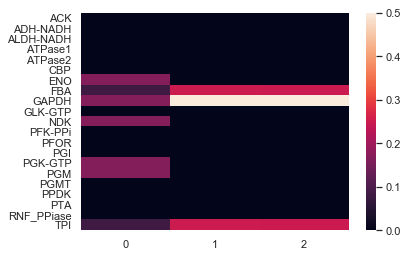

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
fng_data={}
for t in range(3):
    fng_data[t]={}
    for r in all_data[t]['mdf'].reaction_data:
        fng_data[t].update({r.reaction.reaction_id: float(r.shadow_price)})
        print (r.reaction.reaction_id,r.dGr,r.shadow_price)
    k=0
    print(all_data[t]['mdf'].mdf)
    tem_c = all_data[t]['mdf'].compound_data    
    for c in tem_c:
        if 1:#c.shadow_price!=0:
            print(ktaDict[c.compound], c.concentration,all_data[t]['conc'][k],c.lb,c.ub,c.shadow_price)
        #elif ktaDict[c.compound] in ["nadh","g3p","dhap"]:
            #print(ktaDict[c.compound], c.concentration,all_data[t]['conc'][k],c.lb,c.ub,c.shadow_price)
        k=k+1
df = pd.DataFrame.from_dict(fng_data)
sns.heatmap(df,xticklabels=True, yticklabels=True)

ATPase1 0.0
CBP 0.0
GLK-GTP 6.721491463453975e-17
PGMT -1.8161543077082945e-17
PGI 0.0
PFK-PPi -1.680372865863494e-16
FBA 0.08333333333333331
TPI 0.08333333333333331
GAPDH 0.1666666666666668
PGK-GTP 0.16666666666666677
PGM 0.16666666666666663
ENO 0.16666666666666696
PPDK 0.0
PFOR 0.0
RNF_PPiase 0.0
ALDH-NADH 0.0
ADH-NADH -1.2322734349665623e-16
NDK 0.16666666666666669
ATPase2 0.0
PTA 0.0
ACK 0.0
h2o 1.0 (1.0, 1.0) 1.0 1.0 -0.41293775000000066
nad 0.00010000000000000026 (0.00010000000000000009, 0.00010000000000000009) 0.0001 0.0001 0.41293775000000055
nadh 1.0000000000000112e-06 (9.999999999999987e-07, 1.00000000000002e-06) 1e-06 0.01 -0.41293775000000055
adp 0.00010000000000000009 (0.00010000000000000009, 0.00010000000000000009) 0.0001 0.0001 0.41293775
pi 0.010000000000000031 (0.010000000000000014, 0.010000000000000014) 0.01 0.01 0.41293775000000066
co2 9.99999999999998e-06 (9.999999999999997e-06, 9.999999999999997e-06) 1e-05 1e-05 0.0
amp 0.00010000000000000009 (0.0001000000000000000

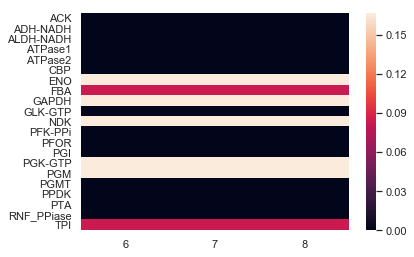

In [38]:
fng_data={}
for t in range(6,9):
    fng_data[t]={}
    for r in all_data[t]['mdf'].reaction_data:
        fng_data[t].update({r.reaction.reaction_id: float(r.shadow_price)})
        print (r.reaction.reaction_id,r.shadow_price)
    k=0
    tem_c = all_data[t]['mdf'].compound_data    
    for c in tem_c:
        if (all_data[t]['conc'][k][0]==all_data[t]['conc'][k][1]):
            print(ktaDict[c.compound], c.concentration,all_data[t]['conc'][k],c.lb,c.ub,c.shadow_price)
        elif ktaDict[c.compound] in ["nadh","g6p","f6p"]:
            print(ktaDict[c.compound], c.concentration,all_data[t]['conc'][k],c.lb,c.ub,c.shadow_price)
        k=k+1    
df = pd.DataFrame.from_dict(fng_data)
sns.heatmap(df,xticklabels=True, yticklabels=True)

In [242]:
# average using amount_int
# impose only one concentration bound at a time to check for infeasible bounds
all_data={}
Uf = 0.01 #Uncertainity factor 
DEFAULT_LB = 1e-6
DEFAULT_UB = 2e-2 #20 mM, which is 2x higher than the 10 mM default bound suggested in the Noor et al. 2014 paper.

ref_conc={}
count={}
for i, dat in Met_data.iterrows():
    if dat['Timepoint']!=2 and dat['Sample']=='B':
        if dat['KEGG_ID'] not in ref_conc:
            ref_conc[dat['KEGG_ID']]=0
            count[dat['KEGG_ID']]=0
        else:
            ref_conc[dat['KEGG_ID']]=(ref_conc[dat['KEGG_ID']]+dat['amount_int'])
            count[dat['KEGG_ID']]=count[dat['KEGG_ID']]+1
for sm in range(12): # divide the samples into datasets
    all_data[sm]={}
    if sm < 6:
        smple = 'A'
    else:
        smple = 'B'
    if (sm)%3==0:
        tym = 2
    elif (sm)%3==1:
        tym = 5
    else:
        tym = 9
    if sm<3 or (sm<9 and sm>5):
        rep = 1
    else:
        rep = 2
    #print(smple,tym,rep)
    for i, cpd in Met_bound.iterrows():  # reset bounds at the start of each iteration
        pp.bounds.SetBounds(cpd['KEGG_ID'],cpd['Concentration:Min'],cpd['Concentration:Max'] )
    for i2, dat2 in Met_data_WT.iterrows():
        if dat2['KEGG_ID'] not in ['C00044','C00035','C00002','C00004','C00005','C00008','C00003','C00020','C00197','C00111']:
            #pp.bounds.SetBounds(dat['KEGG_ID'],dat['Concentration']*.50,dat['Concentration']*1.5)
            lb={}
            ub={}
            for i, dat in Met_data.iterrows():
                try:
                    if (dat2['KEGG_ID']==dat['KEGG_ID'])and(dat['Sample']==smple and dat['Timepoint']==tym and dat['Replicate']==rep) and (dat['KEGG_ID'] not in ['C00035',"C00044","C00002","C00004","C00005"]):
                        all_data[sm][i]={}
                        if dat['KEGG_ID'] not in lb:
                            lb[dat['KEGG_ID']]={}
                        if dat['KEGG_ID'] not in ub:
                            ub[dat['KEGG_ID']]={}
                        if not lb[dat['KEGG_ID']]:
                            lb[dat['KEGG_ID']] = dat['amount_int']/1e6#*dat2['Concentration']/(ref_conc[dat['KEGG_ID']]) *(1-Uf)*count[dat['KEGG_ID']]
                        else:
                            lb[dat['KEGG_ID']] = (lb[dat['KEGG_ID']]+dat['amount_int']*dat2['Concentration']/(ref_conc[dat['KEGG_ID']]) *(1-Uf))*count[dat['KEGG_ID']]/2
                            if lb[dat['KEGG_ID']] < DEFAULT_LB:    
                                lb[dat['KEGG_ID']] = DEFAULT_LB

                            if lb[dat['KEGG_ID']] > DEFAULT_UB:
                                lb[dat['KEGG_ID']] = DEFAULT_UB
                        if not ub[dat['KEGG_ID']]: 
                            ub[dat['KEGG_ID']] = dat['amount_int']/1e6#*dat2['Concentration']/(ref_conc[dat['KEGG_ID']]) *(1+Uf)*count[dat['KEGG_ID']]
                        else:
                            ub[dat['KEGG_ID']] = (ub[dat['KEGG_ID']]+dat['amount_int']*dat2['Concentration']/(ref_conc[dat['KEGG_ID']]) *(1+Uf))*count[dat['KEGG_ID']]/2
                            if ub[dat['KEGG_ID']] < DEFAULT_LB:
                                ub[dat['KEGG_ID']] = DEFAULT_LB

                            if ub[dat['KEGG_ID']] > DEFAULT_UB:
                                ub[dat['KEGG_ID']] = DEFAULT_UB
                        #if dat['KEGG_ID']=='C00085':
                        #print(dat['KEGG_ID'],ref_conc[dat['KEGG_ID']],dat2['Concentration'],lb[dat['KEGG_ID']],ub[dat['KEGG_ID']],dat['amount_int'])
                        pp.bounds.SetBounds(dat['KEGG_ID'], lb[dat['KEGG_ID']], ub[dat['KEGG_ID']])
                        #print(dat['KEGG_ID'], lb[dat['KEGG_ID']], ub[dat['KEGG_ID']])
                except:
                    print("ref not found for",dat['KEGG_ID'])
                    #print(dat['KEGG_ID'], lb, ub)
                if tym  == 2 and smple == 'A':
                    pp.bounds.SetBounds('C00469', 5.12/46, 5.12/46)
                    pp.bounds.SetBounds('C00033', 2.87/1000, 2.87/1000)
                elif tym ==5 and smple == 'A':
                    pp.bounds.SetBounds('C00469', 20.21/46, 20.21/46)
                    pp.bounds.SetBounds('C00033', 4.25/1000, 4.25/1000)
                elif tym ==9 and smple == 'A':
                    pp.bounds.SetBounds('C00469', 40.38/46, 40.38/46)
                    pp.bounds.SetBounds('C00033', 4.39/1000, 4.39/1000)
                if tym  == 2 and smple == 'B':
                    pp.bounds.SetBounds('C00469', 0.2/46, 0.2/46)
                    pp.bounds.SetBounds('C00033', 3.21/1000, 3.21/1000)
                elif tym ==5 and smple == 'B':
                    pp.bounds.SetBounds('C00469', 0.47/46, 0.47/46)
                    pp.bounds.SetBounds('C00033', 8.61/1000, 8.61/1000)
                elif tym ==9 and smple == 'B':
                    pp.bounds.SetBounds('C00469', 0.58/46, 0.58/46)
                    pp.bounds.SetBounds('C00033', 9.21/1000, 9.21/1000)
    mdf_data,con = pp.conc_mdf()
    #print(smple,tym,rep,dat['KEGG_ID'],mdf_data.mdf)
    atp_ratio=1
    gtp_ratio=1
    nadh_ratio=1
    for c in mdf_data.compound_data:
        if c.compound in ['C00002']:
            atp_ratio=atp_ratio*c.concentration
        elif c.compound in ['C00008']:
            atp_ratio=atp_ratio/c.concentration
        elif c.compound in ['C00003']:
            nadh_ratio=nadh_ratio/c.concentration
        elif c.compound in ['C00004']:
            nadh_ratio=nadh_ratio*c.concentration
        elif c.compound in ['C00035']:
            gtp_ratio=gtp_ratio/c.concentration
        elif c.compound in ['C00044']:
            gtp_ratio=gtp_ratio*c.concentration
        print(c.compound, c.concentration,(mdf_data.model.concentration_bounds.GetBoundTuple(c.compound)),c.shadow_price)
    #print('atp_ratio =',atp_ratio)
    #print('gtp_ratio =',gtp_ratio)
    #print('nadh_ratio =',nadh_ratio)
    print(smple,tym,rep,mdf_data.mdf)
    #print("__________________")
    all_data[sm]['sample']=smple
    all_data[sm]['timepoint']=tym
    all_data[sm]['replicate']=rep
    all_data[sm]['conc']=con
    all_data[sm]['mdf']=mdf_data
    #except:
    #print("no ref for", dat2['KEGG_ID'])

C00001 1.0 (1.0, 1.0) -2.236694044263232e-16
C00002 0.016076006382311894 (0.001, 0.02) 0.0
C00003 0.00010000000000000009 (0.0001, 0.0001) 0.0
C00004 2.1094295956614484e-06 (1e-06, 0.01) 0.0
C00008 0.00010000000000000009 (0.0001, 0.0001) 1.7106167276332533e-16
C00009 0.009999999999999915 (0.01, 0.01) 0.8258754999999992
C00010 5.223577567647611e-05 (5.223577567647626e-05, 5.223577567647626e-05) -0.4129377499999996
C00011 1.0000000000000016e-05 (1e-05, 1e-05) -2.7369110631344083e-48
C00013 0.019999999999999744 (1e-06, 0.02) 0.0
C00020 0.00010000000000000045 (0.0001, 0.0001) -2.2204460492503136e-16
C00022 0.0001835208499887672 (0.0001835208499887673, 0.0001835208499887673) -2.4651903288156608e-32
C00024 0.00041650865018933125 (0.0004165086501893322, 0.0004165086501893322) 0.4129377499999996
C00031 0.019999999999999886 (1e-06, 0.02) 5.473822126268817e-48
C00033 0.00287 (0.00287, 0.00287) 0.0
C00035 0.00010000000000000026 (0.0001, 0.0001) 2.2140529489154732e-16
C00044 0.02 (0.001, 0.02) -2.2